In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.optim as optim
from torchvision import models
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import os


c:\Users\Reinaldo yang\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The code below is to find the number of genres

In [9]:
df = pd.read_csv('movies.csv')
df.drop_duplicates(inplace = True)

#split the genre column by ; and stack the result
genres= df['Genre'].str.split(';', expand = True).stack()

#find unique values
unique_genres  = genres.unique()
df.head()
print("Total number of genres: ",len(unique_genres))

Total number of genres:  24


## Preprocess the data

In [10]:
df = pd.read_csv('movies.csv')
#remove duplicates and set imdbID as index
df = df.drop_duplicates(subset=["imdbId"], keep="last")
df.set_index("imdbId", inplace=True)

In [11]:
# Create a copy of the dataframe
df_copy = df.copy()

#only take the genre and the local_image_path
df_copy = df_copy[['Genre', 'local_image_path']]

# Split the genre column into a list of genres for each movie
df_copy['Genre'] = df_copy['Genre'].apply(lambda x: x.split(';'))
df_copy.head()

,Genre,local_image_path
imdbId,,
114709,"[Animation, Adventure, Comedy]",images/114709_.jpg
113497,"[Action, Adventure, Family]",images/113497_.jpg
113277,"[Action, Crime, Drama]",images/113277_.jpg
114319,"[Comedy, Drama]",images/114319_.jpg
114576,"[Action, Crime, Thriller]",images/114576_.jpg


In [12]:
# Create an instance of MultiLabelBinarizer and fit_transform the Genre column
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(df_copy['Genre'])
print(mlb.classes_)

# Create a new dataframe with the one-hot encoded genre columns and image paths
df_one_hot = pd.DataFrame({'Genres': list(one_hot), 'local_path': df['local_image_path']})
df_one_hot.head()


['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy' 'Film-Noir' 'History' 'Horror'
 'Music' 'Musical' 'Mystery' 'News' 'Romance' 'Sci-Fi' 'Short' 'Sport'
 'Thriller' 'War' 'Western']


,Genres,local_path
imdbId,,
114709,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",images/114709_.jpg
113497,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",images/113497_.jpg
113277,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",images/113277_.jpg
114319,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",images/114319_.jpg
114576,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",images/114576_.jpg


In [13]:
multihot_dict = df_one_hot["Genres"].to_dict()
print(multihot_dict)

{114709: array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 113497: array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 113277: array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 114319: array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 114576: array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0]), 113189: array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0]), 112346: array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0]), 112896: array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 113987: array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 112760: array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 112641: array([0, 0, 0, 0, 0, 1, 0, 1, 

In [25]:
#training controls
batch_size = 1
number_of_labels = 20
epochs = 10
training_size = 0.7
learning_rate = 0.5 #0.1 #0.01 #0.001
dropout = [0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.15]
# input image dimensions
img_rows, img_cols = 100, 100

In [12]:
# the data holders
x_test = []
x_train = []
y_test = []
y_train = []

#images need to have the same size!!
flist=glob.glob('./images/*.jpg')

length=int(len(flist)*training_size)
i = 0

# print(multihot_dict)
#create lists with input data (images) and output data (multi-hot encoded genre vectors)
for filename in flist:
    # imdb_id = str(filename.split('\\')[-1][:-4]).replace("_","")
    if int(imdb_id) in multihot_dict:
        img = np.array(cv.imread(filename))
        #do transpose so that match pytorch from h.w.c from opencv to c.w.h
        img = np.swapaxes(img, 2, 0)
        #do transpose so that match pytorch from c.w.h from opencv to c.h.w
        img = np.swapaxes(img, 2, 1)

        genre_arr = np.empty([24])

        for j in range(len(multihot_dict[imdb_id])):
            genre_arr[j] = multihot_dict[imdb_id][j]

        if i < length:
            x_train.append(img)
            y_train.append(genre_arr)
        else:
            x_test.append(img)
            y_test.append(genre_arr)

        i += 1
    # else:
    #     print(f"imdb_id {imdb_id} not found in multihot_dict")


ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

In [19]:
print(len(x_train))
print(len(y_train))

print(len(x_train[0]))
print(len(y_train[0]))

print(len(x_test[0]))
print(len(y_test[0]))

2849
2849
3
24
3
24


In [22]:
#converting the data from lists to numpy arrays
x_train=np.asarray(x_train,dtype=float)
x_test=np.asarray(x_test,dtype=float)
y_train=np.asarray(y_train,dtype=float)
y_test=np.asarray(y_test,dtype=float)

#scaling down the RGB data
x_train /= 255
x_test /= 255

#printing stats about the features
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

train_length = x_train.shape[0]

x_train=torch.from_numpy(x_train)
x_test=torch.from_numpy(x_test)
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)

train = data_utils.TensorDataset(x_train, y_train)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

test = data_utils.TensorDataset(x_test, y_test)
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=False)

x_train shape: (2849, 3, 268, 182)
2849 train samples
1222 test samples


In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True) 

for param in model.parameters():
    param.requires_grad = False 

model.classifier = nn.Sequential(
    nn.Linear(1024, 24),
    nn.Sigmoid()
)

model.double() 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"model loaded on {device}")
model.to(device)
print(model)

Using cache found in C:\Users\Reinaldo yang/.cache\torch\hub\pytorch_vision_v0.10.0


model loaded on cuda:0
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0) #TODO: check best params here

In [31]:
# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval() #TODO: check model.train() which is used along model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"model testing on {device}")
        some_accuracy_measure = 0
        final_accuracy = 0
        for i, (images, labels) in enumerate(test_loader,0):
            sum = 0
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            outputs = model(images) 
            # print(outputs)
            for j, label in enumerate(labels):
              n = sum + label.sum().item()
              # get the top n values of outputs
              _, predicted = torch.topk(outputs[j], int(n)) #TODO: find best threshold and calc F1.
              
              correct_predictions = 0
              for _, k in enumerate(predicted):
                if(label[k.item()].item() == 1):
                  correct_predictions += 1
                some_accuracy_measure = correct_predictions/n
            final_accuracy += some_accuracy_measure  
            # the label with the highest energy will be our prediction
            #_, predicted = torch.max(outputs.data, 1)
            #print("Predicted: ", predicted)
            total += labels.size(0)
            
            #accuracy += (predicted == labels).sum().item()
    print("Total: ", total)
    # compute the accuracy over all test images
    #accuracy = (100 * accuracy / total)
    accuracy = final_accuracy * 100 /total
    print("Accuracy;: ", accuracy)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            #labels = labels.unsqueeze_(0)
            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 0:    
                # print every 1000 (twice per epoch) 
                #print('[%d, %5d] loss: %.3f' %
                #      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy() #BUG: why is this in for loop? 
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [17]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [33]:
train(epochs)

The model will be running on cuda:0 device
model testing on cuda:0
Total:  1222.0
Accuracy;:  100.0
For epoch 1 the test accuracy over the whole test set is 100 %
model testing on cuda:0
Total:  1222.0
Accuracy;:  100.0
For epoch 2 the test accuracy over the whole test set is 100 %


KeyboardInterrupt: 

Use prediction to show image

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 250, 250, 3] to have 3 channels, but got 250 channels instead

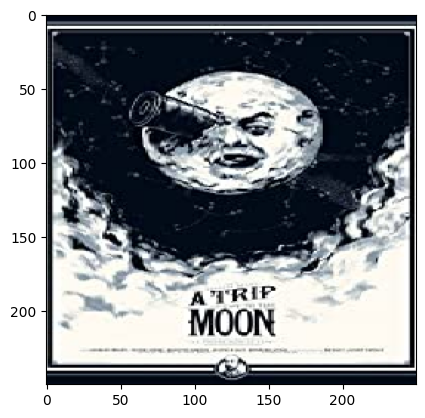

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing import image


model.load_state_dict(torch.load('myFirstModel.pth'))
model.eval()
width = 250
height = 250
img = image.load_img('./images/417_.jpg',target_size=(width,height,3))
plt.imshow(img)


img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1,width,height,3)
classes = df_one_hot.columns[1:]
y_pred = model(torch.from_numpy(img))
top3=np.argsort(y_pred[0])[:-4:-1]
for i in range(3):
  print(classes[top3[i]])

In [28]:
def predict(cnn, location):

    img = image.load_img(location,target_size=(400,300,3))
    img = image.img_to_array(img)
    img = img/255

    img =  Variable(torch.from_numpy(img)).transpose(0,2).transpose(1,2).to(device)
    img = img.view(1,3,400,-1)
    proba = cnn(img)

    classes = np.array(train.columns[2:])
    proba = proba.cpu().detach().numpy()
    top_3 = np.argsort(proba[0])[:-4:-1]
    for i in range(3):
        print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))

In [ ]:
predict(model, './images/100029_.jpg')

In [ ]:
def poster_classification(img_idx, target_key=target_key, model=model):
    
    img_num = img_idx
    img_path_find = image_paths[img_num]
    img_height = 268
    img_width = 182

    img_test_predict = np.array([img_to_array(
                        load_img(image_paths[img_num], target_size=(img_height, img_width)))])
    img_test_predict = img_test_predict.astype('float32')/255.0


    results = {}
    img = img_test_predict
    proba = model.predict(img)[0]
    idxs = np.argsort(proba)[::-1][:2]

    for j in range(0, len(proba)):
        results[target_key[j]] = proba[j] * 100

    results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
    top_4 = take(4, results.items())
    print(top_4)
    
    print(df_movie.query('image_path == @img_path_find')['Genre'].to_list()[0])
            
    plt.imshow(img[0]);
    plt.grid(True);
    plt.xticks([]);
    plt.yticks([]);